#### Understanding the trajectories amongst individual.

The following cells will inspect how individual are moving across profiles between time point, and which factors are driving those trajectories.

In [ ]:
# Imports
import os

import numpy as np
import pandas as pd
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import font_manager
import seaborn as sns

In [2]:
# Setting up relevant paths.
repository_path = "/Users/anthonygagnon/code/Article-s-code/" # CHANGE THIS
abcd_base_path = "/Volumes/T7/CCPM/ABCD/Release_5.1/abcd-data-release-5.1/" # CHANGE THIS
output_folder = "/Volumes/T7/CCPM/RESULTS_JUNE_24/LongitudinalProfiles" # CHANGE THIS

# Setting up the paths for output subfolder.
output_dir = f"{output_folder}/trajectories/" # DO NOT CHANGE THIS
os.makedirs(output_dir, exist_ok=True)

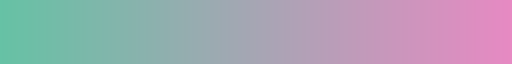

In [3]:
# Fetch Harding font.
font_files = []
for fontpath in font_manager.findSystemFonts(fontpaths=None, fontext='ttf'):
    if "Harding".lower() in fontpath.lower():
        font_files.append(fontpath)
for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

# Set Harding font.
plt.rcParams['font.family'] = 'Harding Text Web'

# Set the Set2 color palette as an iterable.
cmap = sns.color_palette("Set2", 8)

# Continuous color palette.
set2 = plt.get_cmap("Set2")
color_start = set2(0)
color_end = set2(3)
custom_cmap = LinearSegmentedColormap.from_list("CustomSet2", [color_start, color_end])
custom_cmap

In [4]:
# Fetch the profiles data for each timepoint.
df_baseline = pd.read_excel(f"{output_folder}/../fuzzyclustering/merged_fcm_data.xlsx")
df_2y = pd.read_excel(f"{output_folder}/fuzzyclustering/fcm_2y.xlsx")
df_4y = pd.read_excel(f"{output_folder}/fuzzyclustering/fcm_4y.xlsx")

In [5]:
# Fetch the labels of the main cluster.
df_baseline["main_profile"] = np.argmax(df_baseline.iloc[:, 28:32].values, axis=1)
df_2y["main_profile"] = np.argmax(df_2y.iloc[:, 28:32].values, axis=1)
df_4y["main_profile"] = np.argmax(df_4y.iloc[:, 19:23].values, axis=1)

# Create a list containing only the subjects that are common to all timepoints.
common_subjects = list(set(df_baseline["subjectkey"]) & set(df_2y["subjectkey"]) & set(df_4y["subjectkey"]))
print(f"Number of common subjects: {len(common_subjects)}")

# Filter the dataframes to keep only the common subjects.
df_baseline = df_baseline[df_baseline["subjectkey"].isin(common_subjects)]
df_2y = df_2y[df_2y["subjectkey"].isin(common_subjects)]
df_4y = df_4y[df_4y["subjectkey"].isin(common_subjects)]

Number of common subjects: 2359


In [36]:
# Define the labels for the main profiles
labels = ["MC/HSI", "MC/HE", "HC/LB", "LC/LB",
          "MC/HSI", "MC/HE", "HC/LB", "LC/LB",
          "MC/HSI", "MC/HE", "HC/LB", "LC/LB"]

# Set custom nodes positions.
node_positions_x = [0, 0, 0, 0, 0.5, 0.5, 0.5, 0.5, 1, 1, 1, 1]
node_positions_y = [0.5, 0.4, 0.3, 0.2, 0.2, 0.8, -0.1, 1.1, 0, 0, 0, 0]

# Define the colors for each profile using the Set2 colormap
colors = []
for i in range(4):
    rgba = custom_cmap(i / 3 * 0.80)
    r, g, b = [float(c) * 255 for c in rgba[:3]]
    colors.append(f"rgba({r:.0f}, {g:.0f}, {b:.0f}, 1)")
colors *= 3  # Repeat for each time point

# Define the source and target indices for the Sankey diagram
source = []
target = []
value = []
link_colors = []

# Count the transitions from baseline to 2y
for i in range(4):
    for j in range(4):
        count = ((df_baseline["main_profile"].values == i) & (df_2y["main_profile"].values == j)).sum()
        if count > 0:
            source.append(i)
            target.append(4 + j)
            value.append(count)
            rgba = custom_cmap(i / 3 * 0.80)
            r, g, b = [float(c) * 255 for c in rgba[:3]]
            link_colors.append(f"rgba({r:.0f}, {g:.0f}, {b:.0f}, 1)")

# Count the transitions from 2y to 4y
for i in range(4):
    for j in range(4):
        count = ((df_2y["main_profile"].values == i) & (df_4y["main_profile"].values == j)).sum()
        if count > 0:
            source.append(4 + i)
            target.append(8 + j)
            value.append(count)
            rgba = custom_cmap(i / 3 * 0.80)
            r, g, b = [float(c) * 255 for c in rgba[:3]]
            link_colors.append(f"rgba({r:.0f}, {g:.0f}, {b:.0f}, 1)")

# Create the Sankey diagram
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=35,  # Increase the pad for the middle time point
        thickness=20,
        line=dict(color="black", width=1.5),
        label=labels,
        color=colors,
        x=node_positions_x,
        y=node_positions_y
    ),
    link=dict(
        source=source,
        target=target,
        value=value,
        color=link_colors,
    ),
)])

# Add annotations for the time points
#txt = "<b>Figure 1.</b> Sankey Diagram of ABCD's participants transition between profiles from baseline to <br> 2-year follow-up and 2-year follow-up to 4-year follow-up. "
fig.update_layout(
    #title_text=txt,
    autosize=True,
    margin=dict(l=50, r=50, t=100, b=100),
    title_x=0.5,
    title_y=0.07,
    font_size=20,
    font_family="Harding Text Web",
    annotations=[
        dict(x=-0.02, y=1.35, text="9-11 years old", showarrow=False, font=dict(size=20, weight="bold")),
        dict(x=0.5, y=1.35, text="11-13 years old", showarrow=False, font=dict(size=20, weight="bold")),
        dict(x=1, y=1.35, text="13-15 years old", showarrow=False, font=dict(size=20, weight="bold"))
    ]
)
fig.update_yaxes(automargin=True)

fig.show()
fig.write_image(f"{output_dir}/sankey_diagram.svg", scale=2, width=1000, height=700)

In [7]:
# Let's create groups of trajectories based on their main profile across timepoints.
# Starting by merging the dataframes to keep only the common subjects.
common_subjects = set(df_baseline["subjectkey"]).intersection(set(df_2y["subjectkey"])).intersection(set(df_4y["subjectkey"]))
df_merged = pd.merge(df_baseline[df_baseline["subjectkey"].isin(common_subjects)],
                        df_2y[df_2y["subjectkey"].isin(common_subjects)],
                        on="subjectkey", suffixes=("_baseline", "_2y"))
df_merged = pd.merge(df_merged, df_4y[df_4y["subjectkey"].isin(common_subjects)],
                        on="subjectkey", suffixes=("", "_4y"))

# Create a new column which will contain a value for each trajectory (e.g. "1-2-3" for a subject that went from profile 1 at baseline to profile 2 at 2y and profile 3 at 4y).
df_merged["trajectory"] = df_merged.apply(lambda row: f"{row['main_profile_baseline']+1}-{row['main_profile_2y']+1}-{row['main_profile']+1}", axis=1)

# Reformat subjectkey to remove "_" and add "sub-" prefix.
df_merged["subjectkey"] = df_merged["subjectkey"].str.replace("_", "", regex=False)
df_merged["subjectkey"] = "sub-" + df_merged["subjectkey"]

# Rename subjectkey to be sid.
df_merged.rename(columns={"subjectkey": "sid"}, inplace=True)

# Count the number of subjects in each trajectory.
trajectory_counts = df_merged["trajectory"].value_counts().reset_index()
trajectory_counts.columns = ["trajectory", "count"]

# Print the number of unique trajectories.
print(f"Number of unique trajectories: {len(trajectory_counts)}")

# Print the number of tracjectories with more than 100 subjects.
print(f"Number of trajectories with more than 100 subjects: {len(trajectory_counts[trajectory_counts['count'] > 20])}")

Number of unique trajectories: 64
Number of trajectories with more than 100 subjects: 32


/var/folders/23/p0fh1nrd473dtfz3cx_4g0j00000gn/T/ipykernel_27448/1206691005.py:38: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

/var/folders/23/p0fh1nrd473dtfz3cx_4g0j00000gn/T/ipykernel_27448/1206691005.py:39: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

/var/folders/23/p0fh1nrd473dtfz3cx_4g0j00000gn/T/ipykernel_27448/1206691005.py:41: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



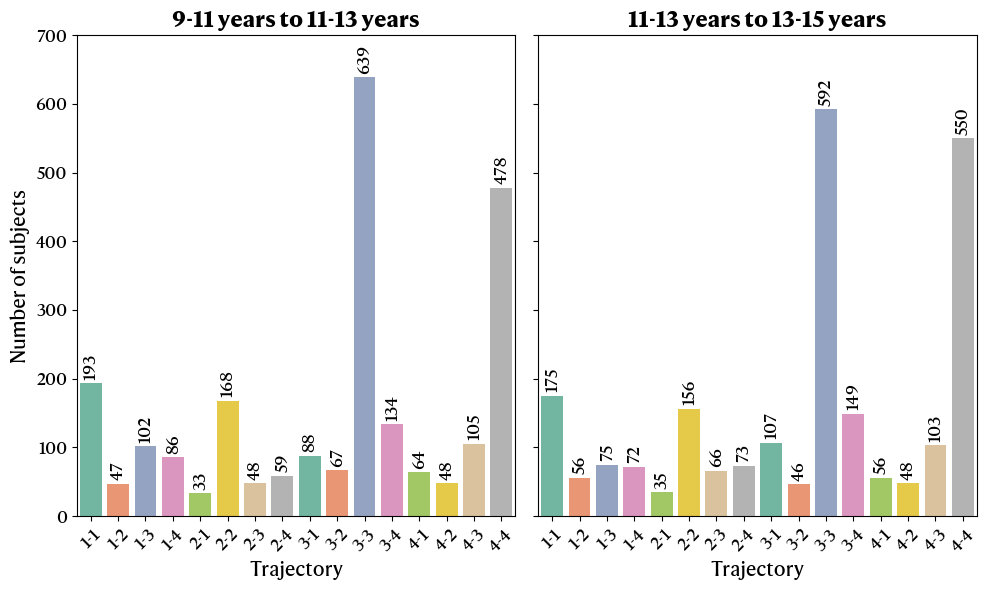

In [33]:
# Compute the number of subjects for the trajectories between baseline and 2y, then 2y and 4y.
trajectory_counts_2y = df_merged.groupby(["main_profile_baseline", "main_profile_2y"]).size().reset_index(name="count")
trajectory_counts_4y = df_merged.groupby(["main_profile_2y", "main_profile"]).size().reset_index(name="count")

# Create a new column for the trajectory.
trajectory_counts_2y["trajectory"] = trajectory_counts_2y.apply(lambda row: f"{row['main_profile_baseline']+1}-{row['main_profile_2y']+1}", axis=1)
trajectory_counts_4y["trajectory"] = trajectory_counts_4y.apply(lambda row: f"{row['main_profile_2y']+1}-{row['main_profile']+1}", axis=1)

# Plot a bar plot of the number of subjects in each trajectory (2 subplots).
fig, axs = plt.subplots(1, 2, figsize=(10, 6), sharey=True)
# Plot the trajectories between baseline and 2y.
bar1 = sns.barplot(data=trajectory_counts_2y, x="trajectory", y="count", hue="trajectory", ax=axs[0], palette="Set2", legend=False)
axs[0].set_title("9-11 years to 11-13 years", fontsize=16, fontweight="bold")
axs[0].set_xlabel("Trajectory", fontsize=14)
axs[0].set_ylabel("Number of subjects", fontsize=14)
axs[0].set_ylim(0, 700)

# Annotate the bar plot with the number of subjects.
for p in bar1.patches:
    bar1.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()+5),
                  ha='center', va='bottom', fontsize=12, color='black', rotation=90)

# Plot the trajectories between 2y and 4y.
bar2 = sns.barplot(data=trajectory_counts_4y, x="trajectory", y="count", hue="trajectory", ax=axs[1], palette="Set2", legend=False)
axs[1].set_title("11-13 years to 13-15 years", fontsize=16, fontweight="bold")
axs[1].set_xlabel("Trajectory", fontsize=14)
axs[1].set_ylabel("Number of subjects", fontsize=14)

# Annotate the bar plot with the number of subjects.
for p in bar2.patches:
    bar2.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()+5),
                  ha='center', va='bottom', fontsize=12, color='black', rotation=90)

# Rotate the x labels.
axs[0].tick_params(axis='x', rotation=45)
axs[1].tick_params(axis='x', rotation=45)
# Set the font size.
axs[0].set_xticklabels(axs[0].get_xticklabels(), fontsize=12)
axs[1].set_xticklabels(axs[1].get_xticklabels(), fontsize=12)
# Increase the size of the y labels.
axs[0].set_yticklabels(axs[0].get_yticklabels(), fontsize=12)

plt.tight_layout()
plt.savefig(f"{output_dir}/trajectories_barplot.png", dpi=600, bbox_inches='tight')

In [11]:
# Compute the percentage of subjects that stayed in the same profile across timepoints.
def compute_stability_percentage(df, timepoint1, timepoint2):
    """
    Compute the percentage of subjects that stayed in the same profile across two timepoints.
    """
    total_subjects = len(df)
    if total_subjects == 0:
        return 0
    same_profile_count = ((df[f"main_profile{timepoint1}"] == df[f"main_profile{timepoint2}"]).sum())
    return (same_profile_count / total_subjects) * 100

# Compute the stability percentage between baseline and 2y.
stability_baseline_2y = compute_stability_percentage(df_merged, "_baseline", "_2y")

# Compute the stability percentage between 2y and 4y.
stability_2y_4y = compute_stability_percentage(df_merged, "_2y", "")

# Print the stability percentages.
print(f"Stability percentage between Baseline and 2y: {stability_baseline_2y:.2f}%")
print(f"Stability percentage between 2y and 4y: {stability_2y_4y:.2f}%")

Stability percentage between Baseline and 2y: 62.65%
Stability percentage between 2y and 4y: 62.44%


In [14]:
# Compute which profile has the highest movement across timepoints.
# Represented by the ratio of the number of subjects that moved to another profile divided by the total number of subjects in that profile.
# For example, if 100 subjects were in profile 1 at baseline and 50 of them moved to another profile at 2y, the movement ratio for profile 1 would be 50/100 = 0.5 or 50%.
def compute_movement_ratio(df, timepoint1, timepoint2):
    """
    Compute the movement ratio for each profile across two timepoints.
    """
    movement_ratios = {}
    for profile in range(4):
        total_subjects = len(df[df[f"main_profile{timepoint1}"] == profile])
        if total_subjects == 0:
            movement_ratios[profile] = 0
            continue
        moved_subjects = len(df[(df[f"main_profile{timepoint1}"] == profile) & (df[f"main_profile{timepoint2}"] != profile)])
        movement_ratios[profile] = moved_subjects / total_subjects
    return movement_ratios

# Compute the movement ratios between baseline and 2y.
movement_ratios_baseline_2y = compute_movement_ratio(df_merged, "_baseline", "_2y")
# Compute the movement ratios between 2y and 4y.
movement_ratios_2y_4y = compute_movement_ratio(df_merged, "_2y", "")
# Print the movement ratios.
print("Movement ratios between Baseline and 2y:")
for profile, ratio in movement_ratios_baseline_2y.items():
    print(f"Profile {profile + 1}: {ratio:.2f} ({ratio * 100:.2f}%)")
print("Movement ratios between 2y and 4y:")
for profile, ratio in movement_ratios_2y_4y.items():
    print(f"Profile {profile + 1}: {ratio:.2f} ({ratio * 100:.2f}%)")


Movement ratios between Baseline and 2y:
Profile 1: 0.55 (54.91%)
Profile 2: 0.45 (45.45%)
Profile 3: 0.31 (31.14%)
Profile 4: 0.31 (31.22%)
Movement ratios between 2y and 4y:
Profile 1: 0.54 (53.70%)
Profile 2: 0.53 (52.73%)
Profile 3: 0.34 (33.78%)
Profile 4: 0.27 (27.34%)


In [17]:
# Compute for each profile, which profile is the most common next profile.
def compute_next_profile_distribution(df, timepoint1, timepoint2):
    """
    Compute the distribution of next profiles for each profile across two timepoints.
    """
    next_profile_distribution = {}
    for profile in range(4):
        next_profiles = df[(df[f"main_profile{timepoint1}"] == profile)][f"main_profile{timepoint2}"].value_counts()
        next_profile_distribution[profile] = next_profiles
    return next_profile_distribution

# Compute the next profile distribution between baseline and 2y.
next_profile_distribution_baseline_2y = compute_next_profile_distribution(df_merged, "_baseline", "_2y")
# Compute the next profile distribution between 2y and 4y.
next_profile_distribution_2y_4y = compute_next_profile_distribution(df_merged, "_2y", "")

# Print the next profile distribution.
print("Next profile distribution between Baseline and 2y:")
for profile, distribution in next_profile_distribution_baseline_2y.items():
    print(f"Profile {profile + 1}:")
    for next_profile, count in distribution.items():
        print(f"  -> Profile {next_profile + 1}: {count} subjects")
print("Next profile distribution between 2y and 4y:")
for profile, distribution in next_profile_distribution_2y_4y.items():
    print(f"Profile {profile + 1}:")
    for next_profile, count in distribution.items():
        print(f"  -> Profile {next_profile + 1}: {count} subjects")

Next profile distribution between Baseline and 2y:
Profile 1:
  -> Profile 1: 193 subjects
  -> Profile 3: 102 subjects
  -> Profile 4: 86 subjects
  -> Profile 2: 47 subjects
Profile 2:
  -> Profile 2: 168 subjects
  -> Profile 4: 59 subjects
  -> Profile 3: 48 subjects
  -> Profile 1: 33 subjects
Profile 3:
  -> Profile 3: 639 subjects
  -> Profile 4: 134 subjects
  -> Profile 1: 88 subjects
  -> Profile 2: 67 subjects
Profile 4:
  -> Profile 4: 478 subjects
  -> Profile 3: 105 subjects
  -> Profile 1: 64 subjects
  -> Profile 2: 48 subjects
Next profile distribution between 2y and 4y:
Profile 1:
  -> Profile 1: 175 subjects
  -> Profile 3: 75 subjects
  -> Profile 4: 72 subjects
  -> Profile 2: 56 subjects
Profile 2:
  -> Profile 2: 156 subjects
  -> Profile 4: 73 subjects
  -> Profile 3: 66 subjects
  -> Profile 1: 35 subjects
Profile 3:
  -> Profile 3: 592 subjects
  -> Profile 4: 149 subjects
  -> Profile 1: 107 subjects
  -> Profile 2: 46 subjects
Profile 4:
  -> Profile 4: 550 